In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#import json
from google.cloud import bigquery
from datetime import datetime,timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_validate

from sklearn.metrics import classification_report


In [2]:
#Localisation du projet name et table_id sur gcp
project="marbotic"

In [3]:
#intégration des credentials 
from google.oauth2 import service_account

key_path = "/Users/antonin/code/AntoninAnq/gcp/marbotic-7d02fac30bd8.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

In [4]:
def extract(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT
    COUNT(DISTINCT ep.Activity_Name) as unique_activity, 
    sm.session_id,sum(Time_Spent) as Time_Spent,
    any_value(Action_Element_Name) as Action_Element_Name,
    any_value(Profile_Age_days) as Profile_Age_days,
    (SAFE_DIVIDE(SUM(event_type_Activity_Good_Answer) , (SUM(event_type_Activity_Good_Answer)
    + SUM(event_type_Activity_Wrong_Answer))))*100 as good_answer_ratio
    FROM `marbotic.marbotic_dataset.event_properties` as ep
    JOIN `marbotic.marbotic_dataset.sessions_metrics` as sm on ep.session_id = sm.session_id
    GROUP BY sm.session_id
    ORDER BY unique_activity DESC
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [5]:
#On récupère d'event le nombre d'activity unique par session, le ratio de bonne réponse par sessions et le time spent par sessions
first_data = extract(project,credentials)
first_data

,unique_activity,session_id,Time_Spent,Action_Element_Name,Profile_Age_days,good_answer_ratio
0,42,1.648054e+12,19329.0,Back,1899.0,100.0
1,41,1.646647e+12,21882.0,Back,8434.0,NaN
2,40,1.646297e+12,54083.0,Back,1968.0,100.0
3,39,1.647908e+12,9693.0,Back,2376.0,100.0
4,38,1.646244e+12,16048.0,Back,2227.0,100.0
...,...,...,...,...,...,...
18811,0,1.650445e+12,414.0,None,NaN,NaN
18812,0,1.650582e+12,371.0,None,NaN,NaN
18813,0,1.650516e+12,5286.0,None,NaN,NaN
18814,0,1.650721e+12,2110.0,None,NaN,NaN


In [6]:
def extract_session_metrics(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT *
    FROM `marbotic.marbotic_dataset.sessions_metrics`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [7]:
session_metrics_df = extract_session_metrics(project,credentials)
session_metrics_df

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear,session_start,game_events,setup_events
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,0.0,0.0,0.0,5.0,1.0,0.0,0.0,2022-03-16 08:56:40.722000+00:00,6.0,0.0
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2022-03-16 08:58:28.269000+00:00,5.0,0.0
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2022-03-24 15:06:21.426000+00:00,5.0,0.0
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2022-03-16 08:57:48.381000+00:00,5.0,0.0
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2022-03-07 08:24:40.937000+00:00,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.646491e+12,Notting Hill Gate,English,15.1,Royal Kensington and Chelsea,United Kingdom,iPad 6,1.0.7,2022-03-05 14:40:14.517000+00:00,5,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2022-03-05 14:39:48.894000+00:00,5.0,0.0
18812,1.652027e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 16:39:55.181000+00:00,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-08 16:32:21.326000+00:00,0.0,0.0
18813,1.652029e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 17:01:24.501000+00:00,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-08 16:58:54.378000+00:00,0.0,0.0
18814,1.652377e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-12 18:05:34.559000+00:00,19,...,0.0,0.0,0.0,10.0,4.0,0.0,0.0,2022-05-12 17:38:47.898000+00:00,19.0,0.0


In [8]:
#on merge les première colonnes crées avec la table sessions metrics
sm_df = session_metrics_df.merge(first_data, on='session_id')

In [9]:
#Calcul du temps de chaque session
sm_df['duration_min'] = (sm_df['session_end']-sm_df['session_start']).apply(lambda x: x.total_seconds()/60)

In [10]:
sm_df

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,event_type_Toast_Disappear,session_start,game_events,setup_events,unique_activity,Time_Spent,Action_Element_Name,Profile_Age_days,good_answer_ratio,duration_min
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,0.0,2022-03-16 08:56:40.722000+00:00,6.0,0.0,0,37.0,None,-1.0,NaN,1.558200
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,0.0,2022-03-16 08:58:28.269000+00:00,5.0,0.0,0,25.0,None,-1.0,NaN,0.285183
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,0.0,2022-03-24 15:06:21.426000+00:00,5.0,0.0,0,28.0,None,-1.0,NaN,0.240200
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,0.0,2022-03-16 08:57:48.381000+00:00,5.0,0.0,0,20.0,None,-1.0,NaN,0.191067
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,0.0,2022-03-07 08:24:40.937000+00:00,6.0,0.0,0,858.0,Back,1891.0,NaN,0.980767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.646491e+12,Notting Hill Gate,English,15.1,Royal Kensington and Chelsea,United Kingdom,iPad 6,1.0.7,2022-03-05 14:40:14.517000+00:00,5,...,0.0,2022-03-05 14:39:48.894000+00:00,5.0,0.0,0,31.0,None,-1.0,NaN,0.427050
18812,1.652027e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 16:39:55.181000+00:00,17,...,0.0,2022-05-08 16:32:21.326000+00:00,0.0,0.0,0,2525.0,None,4930.0,NaN,7.564250
18813,1.652029e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 17:01:24.501000+00:00,20,...,0.0,2022-05-08 16:58:54.378000+00:00,0.0,0.0,1,834.0,None,4930.0,NaN,2.502050
18814,1.652377e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-12 18:05:34.559000+00:00,19,...,0.0,2022-05-12 17:38:47.898000+00:00,19.0,0.0,1,9393.0,Back,4934.0,100.0,26.777683


In [11]:
def extract_user_metrics(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT user_creation_time, user_id
    FROM `marbotic.marbotic_dataset.users_metrics`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [12]:
user_metrics_df = extract_user_metrics(project,credentials)

In [13]:
#on merge la date de création dans le cas ou on veut calculer la maturité du user au moment de la session. Non utilisé dans un premier temps
sm_df = sm_df.merge(user_metrics_df, on='user_id')

In [14]:
sm_df

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,session_start,game_events,setup_events,unique_activity,Time_Spent,Action_Element_Name,Profile_Age_days,good_answer_ratio,duration_min,user_creation_time
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,2022-03-16 08:56:40.722000+00:00,6.0,0.0,0,37.0,None,-1.0,NaN,1.558200,2021-11-20 15:17:18.537000+00:00
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,2022-03-16 08:58:28.269000+00:00,5.0,0.0,0,25.0,None,-1.0,NaN,0.285183,2021-11-20 15:17:18.537000+00:00
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,2022-03-24 15:06:21.426000+00:00,5.0,0.0,0,28.0,None,-1.0,NaN,0.240200,2021-11-20 15:17:18.537000+00:00
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,2022-03-16 08:57:48.381000+00:00,5.0,0.0,0,20.0,None,-1.0,NaN,0.191067,2021-11-20 15:17:18.537000+00:00
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,2022-03-07 08:24:40.937000+00:00,6.0,0.0,0,858.0,Back,1891.0,NaN,0.980767,2021-12-07 18:08:20.505000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.649501e+12,Kensington,English,15.1,Royal Kensington and Chelsea,United Kingdom,"iPad12,1",1.0.5,2022-04-09 10:45:26.022000+00:00,1,...,2022-04-09 10:45:26.022000+00:00,1.0,0.0,1,3573.0,None,NaN,NaN,0.000000,2021-12-19 14:16:39.549000+00:00
18812,1.652027e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 16:39:55.181000+00:00,17,...,2022-05-08 16:32:21.326000+00:00,0.0,0.0,0,2525.0,None,4930.0,NaN,7.564250,2022-05-08 16:29:14.356000+00:00
18813,1.652029e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 17:01:24.501000+00:00,20,...,2022-05-08 16:58:54.378000+00:00,0.0,0.0,1,834.0,None,4930.0,NaN,2.502050,2022-05-08 16:29:14.356000+00:00
18814,1.652377e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-12 18:05:34.559000+00:00,19,...,2022-05-12 17:38:47.898000+00:00,19.0,0.0,1,9393.0,Back,4934.0,100.0,26.777683,2022-05-08 16:29:14.356000+00:00


In [15]:
sm_df.columns

Index(['session_id', 'city', 'language', 'os_version', 'region', 'country',
       'device_model', 'start_version', 'session_end', 'id', 'user_id',
       'event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_ConversionClickSubscribe',
       'event_type_Activation_Game', 'event_type_Activation_New_Activation',
       'event_type_Activation_Piece', 'event_type_Activation_Product',
       'event_type_Activity_Good_Answer', 'event_type_Activity_Start',
       'event_type_Activity_Stop', 'event_type_Activity_Wrong_Answer',
       'event_type_Error_Error', 'event_type_Game_Pause',
       'event_type_Game_Start', 'event_type_Game_Stop',
       'event_type_OB_ClickStore', 'event_type_OB_ClickTrial',
       'event_type_OB_CommPreview', 'event_type_OB_DiscoverTrial',
  

In [16]:
#On calcul le nombre de sessions avant celle en cours
def nb_session(user_id,session_start):
    return sm_df[(sm_df['user_id']==user_id) & (sm_df['session_start']<session_start)].shape[0]

In [17]:
sm_df['previous_session'] = sm_df.apply(lambda x:nb_session(x.user_id,x.session_start), axis=1)

In [18]:
#On calcul le temps depuis la dernière sessions
def last_session_time(user_id,session_start):
    last_session = sm_df[(sm_df['user_id']==user_id) & (sm_df['session_start']<session_start)]\
    .sort_values(by='session_start',ascending=True)\
    .groupby('user_id').last()['session_start']
    if len(last_session.values)==0:
        return timedelta(0)
    else:
        last_session = last_session.dt.to_pydatetime()[0].replace(tzinfo=None)
        return (session_start.to_pydatetime().replace(tzinfo=None) - last_session)

In [19]:
#(sm_df[(sm_df['user_id']==65616.0) & (sm_df['session_start']<'2022-03-16 08:58:28.269000+00:00')].sort_values(by='session_start',ascending=True).groupby('user_id').last()['session_start'].dt.to_pydatetime()[0].replace(tzinfo=None))

In [20]:
sm_df['time_since_last_session'] = sm_df.apply(lambda x:last_session_time(x.user_id,x.session_start), axis=1)

In [21]:
#Vérification pour un utilisateur donné, le début de toutes ses sessions ordonné et l'écart avec la dernière session
sm_df[sm_df['user_id']==66337.0].sort_values(by='session_start',ascending=True)[['session_start','time_since_last_session']]

,session_start,time_since_last_session
10,2022-01-12 15:34:18.911000+00:00,0 days 00:00:00
11,2022-03-05 16:00:00.822000+00:00,52 days 00:25:41.911000
9,2022-03-05 20:23:34.583000+00:00,0 days 04:23:33.761000
6,2022-03-07 07:15:12.051000+00:00,1 days 10:51:37.468000
7,2022-03-07 07:52:31.465000+00:00,0 days 00:37:19.414000
4,2022-03-07 08:24:40.937000+00:00,0 days 00:32:09.472000
5,2022-05-09 09:50:43.882000+00:00,63 days 01:26:02.945000
8,2022-05-10 06:57:04.671000+00:00,0 days 21:06:20.789000
12,2022-05-10 14:45:39.525000+00:00,0 days 07:48:34.854000
16,2022-05-11 06:42:18.649000+00:00,0 days 15:56:39.124000


In [22]:
#sm_df.groupby('user_id').agg({'time_since_last_session':'mean','setup_events':sum,'game_events':sum,'id':'count'})['id'].value_counts()

In [23]:
#Durée moyenne entre deux sessions
sm_df[sm_df['time_since_last_session']!=timedelta(0)]['time_since_last_session'].mean()

Timedelta('3 days 04:41:50.486608937')

In [24]:
#Conversion de la colonne time_since_last_session timedelta en timestampe[min]
sm_df['time_since_last_session_min']=sm_df['time_since_last_session'].map(lambda x : x.total_seconds()/60)

**Ajout de la maturité au moment du début de la sessions**

In [25]:
sm_df["week_maturity"] =(sm_df["session_start"]-sm_df["user_creation_time"]).map(lambda x: int(np.ceil(x.days/7))+1)

**Ajout du type d'utilisateur depuis la table user_augmented**

In [26]:
def extract_user_type(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT Type, user_id
    FROM `marbotic.marbotic_dataset.user_augmented`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [27]:
user_type_df = extract_user_type(project,credentials)
user_type_df

,Type,user_id
0,None,0
1,Parent,1220
2,Parent,1405
3,Parent,1957
4,Parent,2560
...,...,...
5249,Parent,73098
5250,Teacher,73127
5251,Teacher,73128
5252,Parent,73132


In [33]:
user_type_df.drop_duplicates(subset='user_id',inplace=True)

In [35]:
sm_df = sm_df.merge(user_type_df, on='user_id')

In [37]:
#Durée moyenne entre deux sessions pour les parents
sm_df[sm_df['Type']=='Parent'][sm_df['time_since_last_session']!=timedelta(0)]['time_since_last_session'].mean()

/var/folders/c7/kdqvz76x679f28lhd235r_v40000gn/T/ipykernel_85788/258057669.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sm_df[sm_df['Type']=='Parent'][sm_df['time_since_last_session']!=timedelta(0)]['time_since_last_session'].mean()


Timedelta('3 days 10:11:01.818812509')

In [38]:
week_maturity = sm_df['week_maturity']
min_last_session = sm_df['time_since_last_session_min']

In [39]:
sm_df['session_start_day'] = sm_df['session_start'].apply(lambda x: x.weekday()+1)

In [40]:
sm_df['session_start_month'] = sm_df['session_start'].apply(lambda x: x.month)

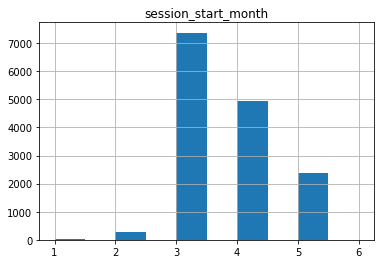

In [41]:
#Gros pic de session au mois de mars (= Merge de l'appli ? puis uniquement décroissance)
sm_df[sm_df['Type']=='Parent'][['session_start_month']].hist();

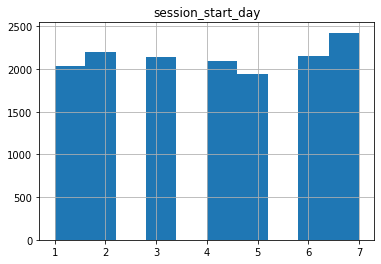

In [42]:
#On ne retrouve pas la saisonalité hebdomadaire annoncée
sm_df[sm_df['Type']=='Parent'][['session_start_day']].hist();

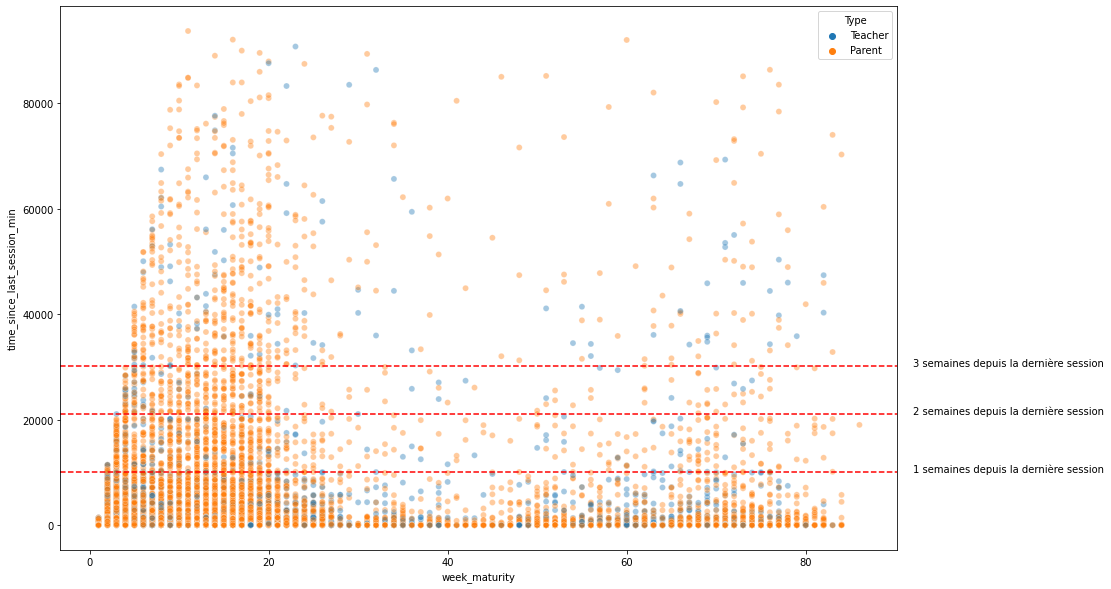

In [43]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x=week_maturity,y=min_last_session,alpha=0.4,hue=sm_df['Type'])

plt.axhline(30240, ls='--', linewidth=1.5, color='red')
plt.text(92,30240, "3 semaines depuis la dernière session")

plt.axhline(21160, ls='--', linewidth=1.5, color='red')
plt.text(92,21160, "2 semaines depuis la dernière session")

plt.axhline(10080, ls='--', linewidth=1.5, color='red')
plt.text(92,10080, "1 semaines depuis la dernière session")

plt.show()

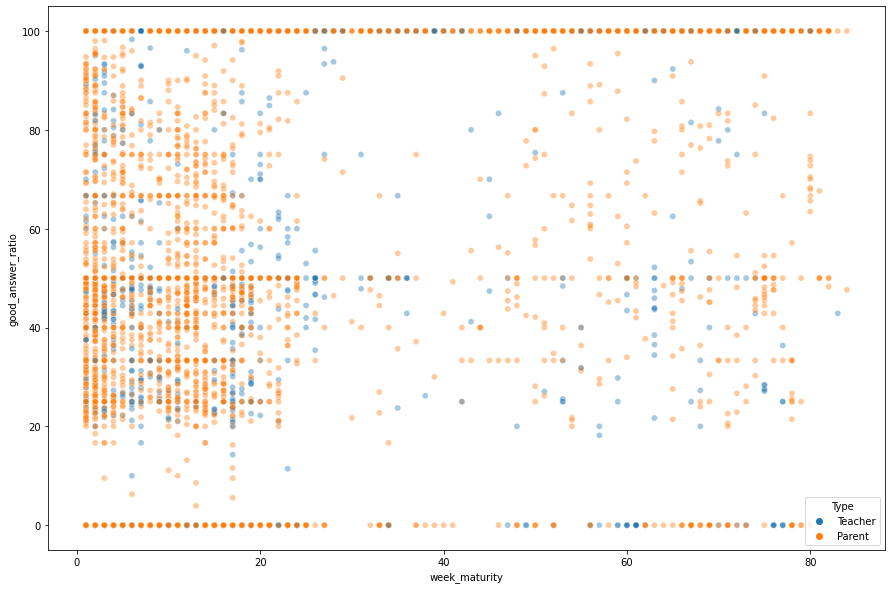

In [44]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x=week_maturity,y=sm_df['good_answer_ratio'],alpha=0.4,hue=sm_df['Type'])

#plt.axhline(30240, ls='--', linewidth=1.5, color='red')
#plt.text(92,30240, "3 semaines depuis la dernière session")

#plt.axhline(21160, ls='--', linewidth=1.5, color='red')
#plt.text(92,21160, "2 semaines depuis la dernière session")

#plt.axhline(10080, ls='--', linewidth=1.5, color='red')
#plt.text(92,10080, "1 semaines depuis la dernière session")
#plt.ylim(0,100)
plt.show()

In [45]:
#On drope la colone time_since_last_session en timedelta car incompatbile BQ
sm_df.drop('time_since_last_session',axis=1,inplace=True)

## Correlation

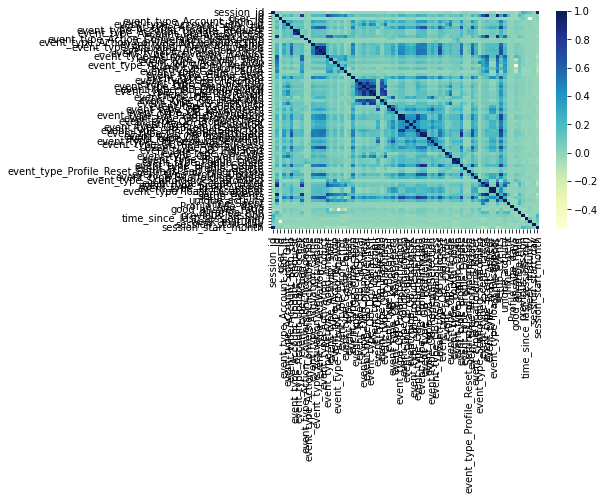

In [46]:
# Heatmap
corr = sm_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu");

In [47]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(20)

,feature_1,feature_2,correlation
4574,event_type_Toast_Disappear,event_type_Toast_Appear,0.990477
4501,event_type_Toast_Appear,event_type_Toast_Disappear,0.990477
2626,event_type_OB_ProductActivation,event_type_OB_ProductHelp,0.951273
2699,event_type_OB_ProductHelp,event_type_OB_ProductActivation,0.951273
4589,game_events,id,0.941049
136,id,game_events,0.941049
5402,session_start_month,session_id,0.934344
73,session_id,session_start_month,0.934344
4647,game_events,event_type_Scene_Leave,0.933703
4428,event_type_Scene_Leave,game_events,0.933703


In [48]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

/var/folders/c7/kdqvz76x679f28lhd235r_v40000gn/T/ipykernel_85788/4073438736.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


In [49]:
to_drop

['event_type_OB_ProductHelp',
 'event_type_OB_ProfileName',
 'event_type_Toast_Disappear',
 'game_events',
 'session_start_month']

## Labelling

In [122]:
#On considère le seuil de churn à 3 semaine.
#On est en situation de churn si la session suivante arrive dans plus de 3 semaines.
CHURN_THRESHOLD = timedelta(days=7)

#On utilise une constante TODAY pour evaluer le risque de churn des dernières session.
#Dans notre cas TODAY est le max de session end. On considère que l'extract s'arrète au moment de la dernière session de jeu dont on dispose
TODAY = datetime(2022, 5, 13, 0, 0)

In [123]:
#sm_df[(sm_df['user_id']==65616.0)& ('2022-03-16 08:58:14.214000+00:00'<sm_df['session_end'])].sort_values(by='session_end',ascending=True).groupby('user_id').first()['session_start']

In [124]:
#On calcul le temps jusqu'à la prochaine sessions si superieur au seuil de churn. Label_risque de churn = 1
def labelling_churn(user_id,session_end,session_start,CHURN_THRESHOLD,today):
    next_session = sm_df[(sm_df['user_id']==user_id) & (session_end<sm_df['session_end'])]\
    .sort_values(by='session_end',ascending=True)\
    .groupby('user_id').first()['session_start']
    if len(next_session.values) == 0:
        if today - session_start.to_pydatetime().replace(tzinfo=None)> CHURN_THRESHOLD :
            return 1
        else:
            return 0
    else:
        delta = (next_session - session_end)
        if delta.iloc[0] < CHURN_THRESHOLD:
            return 0
        else:
            return 1

In [125]:
sm_df['churn_risk'] = sm_df.apply(lambda x:labelling_churn(x.user_id,x.session_end,x.session_start,CHURN_THRESHOLD,TODAY), axis=1)

In [126]:
#Vérification du label de churn sur l'utilisateur déja vérifié plus haut.
sm_df[sm_df['user_id']==66337.0].sort_values(by='session_start',ascending=True)[['session_start','time_since_last_session_min','churn_risk']]

,session_start,time_since_last_session_min,churn_risk
10,2022-01-12 15:34:18.911000+00:00,0.000000,1
11,2022-03-05 16:00:00.822000+00:00,74905.698517,0
9,2022-03-05 20:23:34.583000+00:00,263.562683,0
6,2022-03-07 07:15:12.051000+00:00,2091.624467,0
7,2022-03-07 07:52:31.465000+00:00,37.323567,0
4,2022-03-07 08:24:40.937000+00:00,32.157867,1
5,2022-05-09 09:50:43.882000+00:00,90806.049083,0
8,2022-05-10 06:57:04.671000+00:00,1266.346483,0
12,2022-05-10 14:45:39.525000+00:00,468.580900,0
16,2022-05-11 06:42:18.649000+00:00,956.652067,0


In [127]:
sm_df[sm_df['Type']=='Parent']['churn_risk'].value_counts()

0    11532
1     3457
Name: churn_risk, dtype: int64

In [128]:
(1901/(13090+1901))*100

12.680941898472417

In [129]:
sm_df[sm_df['Type']=='Teacher']['churn_risk'].value_counts()

0    3264
1     559
Name: churn_risk, dtype: int64

In [130]:
(329/(329+3495))*100

8.603556485355648

## Cleaning

In [131]:
#No duplicates
sm_df.duplicated().sum()

0

In [132]:
((sm_df.isnull().sum().sort_values(ascending=False)/len(sm_df))*100).head(10)

session_id                                           0.0
event_type_OB_Success                                0.0
event_type_Profile_Reset_Settings_and_Progression    0.0
event_type_Profile_Delete                            0.0
event_type_Profile_Create                            0.0
event_type_Popup_Open                                0.0
event_type_Popup_Close                               0.0
event_type_OB_VerifCode                              0.0
event_type_OB_Type                                   0.0
event_type_OB_TrialStart                             0.0
dtype: float64

good_answer_ratio Nan correspond to session with no event type answer. On remplace les Nan par -1

In [133]:
answer_ratio_imputer = SimpleImputer(strategy='constant',fill_value=-1)
sm_df['good_answer_ratio'] = answer_ratio_imputer.fit_transform(sm_df[['good_answer_ratio']])

In [134]:
#34% de Nan, on drop cette colonne tant qu'on n'a pas d'information supplémentaire sur la signification des Nan
sm_df['Action_Element_Name'].value_counts()

KeyError: 'Action_Element_Name'

In [ ]:
sm_df.drop('Action_Element_Name',axis=1,inplace=True)

In [135]:
#Pour Profile_Age_days(17%), Time_Spent(0.03) on remplace par la médiane car un énorme outlier(-2911184.0) et 3341 valeur = -1
med_imputer = SimpleImputer(strategy='median')
sm_df['Profile_Age_days'] = med_imputer.fit_transform(sm_df[['Profile_Age_days']])
sm_df['Time_Spent'] = med_imputer.fit_transform(sm_df[['Time_Spent']])

In [136]:
#Pour Type, il manque une valeur on remplace par most frequent
mmost_freq_imputer = SimpleImputer(missing_values=None,strategy='most_frequent')
sm_df['Type'] = mmost_freq_imputer.fit_transform(sm_df[['Type']])

In [137]:
((sm_df.isnull().sum().sort_values(ascending=False)/len(sm_df))*100).head(10)

session_id                                           0.0
event_type_OB_Success                                0.0
event_type_Profile_Reset_Settings_and_Progression    0.0
event_type_Profile_Delete                            0.0
event_type_Profile_Create                            0.0
event_type_Popup_Open                                0.0
event_type_Popup_Close                               0.0
event_type_OB_VerifCode                              0.0
event_type_OB_Type                                   0.0
event_type_OB_TrialStart                             0.0
dtype: float64

**Traitement des outliers extremes**

In [138]:
# A controle Time_spent max, Profile_Age_days min
#On supprime la session avec le time_spent = 17162486.0 de user_id = 23370.0 
#Il a 70 sessions avec une médiane de Time_spent 7571
sm_df[['Time_Spent']].max()

Time_Spent    837348.0
dtype: float64

In [139]:
sm_df.shape

(18812, 86)

In [140]:
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==17162486.0].index,inplace=True)

In [141]:
#On supprime 2 autres lignes avec Time_Spent > 1 000 000 Cela concerne le même utilsateur qui a 20 sessions
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==2190329.0].index,inplace=True)
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==1093473.0].index,inplace=True)

In [142]:
# On supprime l'utilisateur avec un age énorme négatif. Session unique user_creation_time : 27-22-2021
sm_df.drop(axis=0,index=sm_df[sm_df['Profile_Age_days']==-2911184.0].index,inplace=True)

## processing des colonnes

In [143]:
sm_df.select_dtypes(include='object')

,city,language,os_version,region,country,device_model,start_version,Type
0,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,Teacher
1,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,Teacher
2,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,Teacher
3,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,Teacher
4,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,Teacher
...,...,...,...,...,...,...,...,...
18811,Kensington,English,15.1,Royal Kensington and Chelsea,United Kingdom,"iPad12,1",1.0.5,Parent
18812,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,Parent
18813,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,Parent
18814,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,Parent


In [144]:
class CustomOHE(OneHotEncoder):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [145]:
cat_transformer = CustomOHE(sparse = False, handle_unknown = "ignore", drop='if_binary')
cat_selection = sm_df[['Type']].columns

In [146]:
class CustomMinMaxScale(MinMaxScaler):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [147]:
#On retire des éléments très corrélés
num_transformer = CustomMinMaxScale()
num_selection = sm_df.select_dtypes(include=['float64','int64']).drop(['churn_risk','session_id','id','user_id','event_type_Toast_Disappear','event_type_OB_ProductHelp','event_type_OB_ProfileName'],axis=1).columns

In [148]:
class Cyclical_month_Encoder(BaseEstimator, TransformerMixin):
    '''Custom transformer to convert month into cyclical encoding cos and sin'''
    def _init_(self):
        pass 
    
    def fit(self, X,y=None):
        return super().fit(*args, **kwargs) 
    
    def transform(self, X,y=None):
        X = pd.DataFrame(X)
        df = pd.DataFrame()
        cst = (2*np.pi/12)
        df['month_cos'] = X.apply(lambda x: np.cos(cst*x))
        df['month_sin'] = X.apply(lambda x: np.sin(cst*x))
        return df
    
    def fit_transform(self, X,y=None):
        X = pd.DataFrame(X)
        df = pd.DataFrame()
        cst = (2*np.pi/12)
        df['month_cos'] = X.apply(lambda x: np.cos(cst*x))
        df['month_sin'] = X.apply(lambda x: np.sin(cst*x))
        return df
    
    def get_feature_names_out(self,X):
        return 'month_cos','month_sin'

In [149]:
month_transformer = Cyclical_month_Encoder()
month_selection = sm_df[['session_start_month']].columns

In [150]:
class Cyclical_day_Encoder(BaseEstimator, TransformerMixin):
    '''Custom transformer to convert month into cyclical encoding cos and sin'''
    def _init_(self):
        pass 
    
    def fit(self, X,y=None):
        return self
    
    def transform(self, X,y=None):
        X = pd.DataFrame(X)
        df = pd.DataFrame()
        cst = (2*np.pi/7)
        df['day_cos'] = X.apply(lambda x: np.cos(cst*x))
        df['day_sin'] = X.apply(lambda x: np.sin(cst*x))
        return df
    
    def get_feature_names_out(self,X):
        return 'day_cos','day_sin'

In [151]:
day_transformer = Cyclical_day_Encoder()
day_selection = sm_df[['session_start_day']].columns

In [152]:
class CustomColumnTransformer(ColumnTransformer):
    
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs)
    
    def transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().transform(X, *args, **kwargs), columns=self.get_feature_names_out())
    
    def fit_transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(X, *args, **kwargs), columns=self.get_feature_names_out())

In [153]:
sm_df.shape

(18812, 86)

In [154]:
len(num_selection) + len(cat_selection) + len(month_selection) + len(day_selection)

71

In [155]:
preprocessor = CustomColumnTransformer([
    ('num_tr',num_transformer,num_selection),
    ('cat_tr',cat_transformer,cat_selection ),
    ('month_tr',month_transformer,month_selection ),
    ('day_tr',day_transformer,day_selection )],
    remainder = 'drop'
)

In [156]:
sm_df['churn_risk'].value_counts()[1]

4016

## Preparation du jeu de donnée

**On downsample les sessions sans churn risque pour en avoir autant que de churn risque**

In [157]:
def downsample_churn_risk(df):
    sm_df_churn_risque = df[df['churn_risk']==1]
    sm_df_no_churn_risque = df[df['churn_risk']==0]
    sm_df_no_churn_risque = sm_df_no_churn_risque.loc\
    [np.random.choice(sm_df_no_churn_risque.index,size = sm_df_churn_risque.shape[0])]
    
    sm_df_balanced = pd.concat([sm_df_no_churn_risque,sm_df_churn_risque],axis=0)
    X= sm_df_balanced.drop('churn_risk',axis=1).copy()
    y = sm_df_balanced['churn_risk'].copy()
    return X,y

In [158]:
X,y = downsample_churn_risk(sm_df)

On sépare le jeu de donnée en train et test

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Feature selection

In [160]:
X_feature_sel = pd.DataFrame(preprocessor.fit_transform(X_train))

In [161]:
#Permet d'obtenir l'importance des features au regard des autres
#pour chaque modèle on l'entraine 10 fois en mélangeant les valeurs d'une colonne gardant toutes les autres identiques
 
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression().fit(X_feature_sel, y_train) # Fit model
# on peut mettre un keyworld arg max_iter=1000, par défaut le modèle a une limite (100, à vérifier)

permutation_score = permutation_importance(log_model, X_feature_sel, y_train, n_repeats=10) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X_feature_sel.columns,
                                        permutation_score.importances_mean)).T) # Unstack results
importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,feature,score decrease
63,num_tr__previous_session,0.094575
67,num_tr__session_start_month,0.081323
69,month_tr__month_cos,0.05121
68,cat_tr__Type_Teacher,0.012576
64,num_tr__time_since_last_session_min,0.007649
...,...,...
56,num_tr__game_events,-0.001263
54,num_tr__event_type_Scene_Leave,-0.001797
12,num_tr__event_type_Activity_Good_Answer,-0.001832
72,day_tr__day_sin,-0.001921


**La méthode de feature permutation ne donne rien de pertinent**

## Model

In [162]:
class CustomSelectPercentile(SelectPercentile):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [163]:
pipe = make_pipeline(preprocessor,CustomSelectPercentile(percentile=75), RandomForestClassifier())

In [164]:
pipe

Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('num_tr',
                                                        CustomMinMaxScale(),
                                                        Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRedeem',
       'eve...
                                                                  handle_unknown='ignore',
                                                                  sparse=False),
                                                        Index(['Type'], dtype='object')),
                                                       ('month_tr',
                                                        Cyclical_month_Encoder(),
                                                        Index(['session_start_month'], dtype='object')),
                                                       ('day_tr',
                                                        Cyclical_day_Encoder(),
                                                        Index(['session_start_day'], dtype='object'))])),
                ('customselectpercentile',
                 CustomSelectPercentile(percentile=75)),
                ('randomforestclassifier', RandomForestClassifier())])

In [165]:
pipe.get_params()

{'memory': None,
 'steps': [('customcolumntransformer',
   CustomColumnTransformer(transformers=[('num_tr', CustomMinMaxScale(),
                                          Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
          'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
          'event_type_Account_Update_Success', 'event_type_Action_Click',
          'event_type_Action_ConversionClickRedeem',
          'event_type_Action_ConversionClickSubscribe',
          'e...
          'time_since_last_session_min', 'week_maturity', 'session_start_day',
          'session_start_month'],
         dtype='object')),
                                         ('cat_tr',
                                          CustomOHE(drop='if_binary',
                                                    handle_unknown='ignore',
                                                    sparse=False),
                                          Index(['Type'], dtype='object')),
   

In [166]:
grid_search = GridSearchCV(
    pipe, 
    param_grid={
        'randomforestclassifier__n_estimators': [400,450],
        'randomforestclassifier__max_depth': [40],
        'randomforestclassifier__min_samples_split' : [15],
        'randomforestclassifier__max_samples' : [0.8],
        'randomforestclassifier__n_jobs' : [-1]
    },
    cv=5,
    scoring="accuracy",
verbose=1)

In [167]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__max_samples': 0.8,
 'randomforestclassifier__min_samples_split': 15,
 'randomforestclassifier__n_estimators': 400,
 'randomforestclassifier__n_jobs': -1}

In [168]:
grid_search.best_score_

0.7171876631079479

In [169]:
best_search = grid_search.best_estimator_

In [170]:
y_pred = best_search.predict(X_test)

In [171]:
target_names = ['classe 0','Classe 1']
print(classification_report(y_test,y_pred,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.76      0.69      0.72      1183
    Classe 1       0.73      0.78      0.75      1227

    accuracy                           0.74      2410
   macro avg       0.74      0.74      0.74      2410
weighted avg       0.74      0.74      0.74      2410



In [172]:
ran_for_C = RandomForestClassifier(max_depth=40,max_samples= 0.8,min_samples_split= 15, n_estimators=450)
log_reg_C = LogisticRegression(max_iter = 1000,n_jobs=-1, C= 1.5,solver= 'newton-cg')
svc_C = SVC(C= 10,gamma= 1,kernel= 'rbf')
knn_C = KNeighborsClassifier(n_jobs= -1,n_neighbors= 30,p= 1,weights= 'distance')
ada_b_C = AdaBoostClassifier(algorithm= 'SAMME.R',learning_rate= 1,n_estimators= 50)
ridge_C = RidgeClassifier(alpha= 2,max_iter= 1000,solver= 'lsqr')

ensemble = StackingClassifier(
    estimators = [("rf", ran_for_C),
                  ("knn", knn_C),
                  ('log',log_reg_C),
                  ('svc',svc_C),
                  ('ada',ada_b_C),
                  ('ridge',ridge_C)
                 ],
    final_estimator = GradientBoostingClassifier())
stacked_pipe = make_pipeline(preprocessor,CustomSelectPercentile(percentile=50),ensemble)


In [173]:
cv_results_stacked = cross_validate(stacked_pipe, X_train, y_train, scoring='accuracy', cv=5)


/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/

In [174]:
score_stacked = cv_results_stacked['test_score'].mean()
score_stacked

0.7273260577303281

In [175]:
stacked_pipe.fit(X_train, y_train)

/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('num_tr',
                                                        CustomMinMaxScale(),
                                                        Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRedeem',
       'eve...
                                                                        n_estimators=450)),
                                                ('knn',
                                                 KNeighborsClassifier(n_jobs=-1,
                                                                      n_neighbors=30,
                                                                      p=1,
                                                                      weights='distance')),
                                                ('log',
                                                 LogisticRegression(C=1.5,
                                                                    max_iter=1000,
                                                                    n_jobs=-1,
                                                                    solver='newton-cg')),
                                                ('svc', SVC(C=10, gamma=1)),
                                                ('ada',
                                                 AdaBoostClassifier(learning_rate=1)),
                                                ('ridge',
                                                 RidgeClassifier(alpha=2,
                                                                 max_iter=1000,
                                                                 solver='lsqr'))],
                                    final_estimator=GradientBoostingClassifier()))])

In [176]:
y_pred_stacked = stacked_pipe.predict(X_test)

In [177]:
print(classification_report(y_test,y_pred_stacked,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.79      0.63      0.70      1183
    Classe 1       0.70      0.84      0.76      1227

    accuracy                           0.74      2410
   macro avg       0.75      0.74      0.73      2410
weighted avg       0.75      0.74      0.73      2410



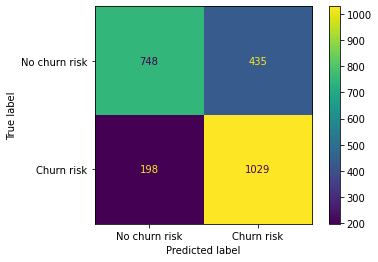

In [178]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label = ['No churn risk', 'Churn risk'] 
cm = confusion_matrix(y_test, y_pred_stacked)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label)
disp.plot();

In [179]:
stacked_pipe.named_steps.keys()

dict_keys(['customcolumntransformer', 'customselectpercentile', 'stackingclassifier'])

In [180]:
#Analyse de la variance des colonnes gardées
pd.DataFrame(stacked_pipe.named_steps["customselectpercentile"].scores_,index=stacked_pipe.named_steps["customselectpercentile"].feature_names_in_).sort_values(by=0,ascending=False)[:33]

,0
num_tr__previous_session,522.688047
num_tr__time_since_last_session_min,84.870248
num_tr__session_start_month,82.218469
month_tr__month_sin,79.941426
cat_tr__Type_Teacher,71.497092
month_tr__month_cos,66.635687
num_tr__Time_Spent,59.231504
num_tr__unique_activity,36.867567
num_tr__week_maturity,34.464642
num_tr__session_start_day,34.342147


**Quels sont les colonnes qui ont été gardée dans le modèle de stacking**

In [181]:
columns_selected_pipe = make_pipeline(preprocessor,CustomSelectPercentile(percentile=50))
columns_selected = columns_selected_pipe.fit_transform(X_train, y_train).columns

/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [182]:
columns_selected = [f[8:] for f in columns_selected]

In [183]:
#33 colonnes gardées
columns_selected

['event_type_Account_Sign_In',
 'event_type_Account_Sign_Up',
 'event_type_Action_Click',
 'event_type_Activation_Game',
 'event_type_Activation_New_Activation',
 'event_type_Activation_Product',
 'event_type_Activity_Good_Answer',
 'event_type_Activity_Start',
 'event_type_Activity_Stop',
 'event_type_Activity_Wrong_Answer',
 'event_type_Game_Pause',
 'event_type_OB_CommPreview',
 'event_type_OB_DoYouHaveKit',
 'event_type_OB_Email',
 'event_type_OB_HasKitYes',
 'event_type_OB_VerifCode',
 'event_type_Scaffolding_Scaffolding',
 'event_type_Scene_Enter',
 'event_type_Scene_Leave',
 'game_events',
 'setup_events',
 'unique_activity',
 'Time_Spent',
 'Profile_Age_days',
 'good_answer_ratio',
 'duration_min',
 'previous_session',
 'time_since_last_session_min',
 'week_maturity',
 'session_start_day',
 'session_start_month',
 'Type_Teacher',
 '__month_cos',
 '__month_sin',
 'day_cos',
 'day_sin']

## Modèle uniquement sur les parents

In [184]:
parent_df = sm_df[sm_df['Type']=="Parent"]

In [185]:
X_parent, y_parent = downsample_churn_risk(parent_df)

In [186]:
X_train_parent, X_test_parent, y_train_parent, y_test_parent = train_test_split(X_parent, y_parent, test_size=0.30)

In [187]:
stacked_pipe.fit(X_train_parent, y_train_parent)

/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 6 68] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('num_tr',
                                                        CustomMinMaxScale(),
                                                        Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRedeem',
       'eve...
                                                                        n_estimators=450)),
                                                ('knn',
                                                 KNeighborsClassifier(n_jobs=-1,
                                                                      n_neighbors=30,
                                                                      p=1,
                                                                      weights='distance')),
                                                ('log',
                                                 LogisticRegression(C=1.5,
                                                                    max_iter=1000,
                                                                    n_jobs=-1,
                                                                    solver='newton-cg')),
                                                ('svc', SVC(C=10, gamma=1)),
                                                ('ada',
                                                 AdaBoostClassifier(learning_rate=1)),
                                                ('ridge',
                                                 RidgeClassifier(alpha=2,
                                                                 max_iter=1000,
                                                                 solver='lsqr'))],
                                    final_estimator=GradientBoostingClassifier()))])

In [188]:
y_pred_parent_stacked = stacked_pipe.predict(X_test_parent)

In [189]:
print(classification_report(y_test_parent,y_pred_parent_stacked,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.75      0.70      0.73      1003
    Classe 1       0.74      0.78      0.76      1072

    accuracy                           0.74      2075
   macro avg       0.74      0.74      0.74      2075
weighted avg       0.74      0.74      0.74      2075



## Upload dans BQ

**Upload de la table en cours dans BQ**

In [190]:
###Localisation du projet name et table_id sur gcp
#project="marbotic"
#table_id = "marbotic_dataset.session_augmented"
#client = bigquery.Client(project,credentials)
#
#job = client.load_table_from_dataframe(sm_df, table_id) 
#
#job.result()  # Wait for the job to complete.
#table = client.get_table(table_id)  # Make an API request.
#print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))

In [191]:
9000/(50)

180.0

In [192]:
180/2

90.0